## Competitive Multi-Agent Reinforcement Learning (CompMARL): with Communication only when Training (A2C as base)

多组单智能体.

critic共享state,但是actor不共享state.

基于A2C

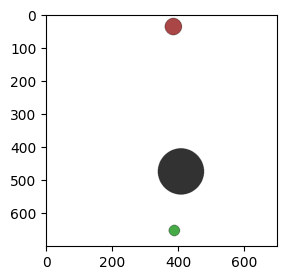

In [1]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  
  def __init__(self):
    from pettingzoo.mpe import simple_tag_v3
    env = simple_tag_v3.env(num_good=1,
                            num_adversaries=1,
                            num_obstacles=1,
                            max_cycles=1e8,
                            render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
    
  def reset(self):
    self.env.reset()
    self.step_n = 0    
    return self.state()
  
  def state(self):
    state = []
    for i in self.env.agents:
      state.append(env.observe(i).tolist())
    state[-1].extend([0.0, 0.0])
    return state
  
  def step(self, action):
    reward_sum = [0, 0]
    for i in range(5):
      if i != 0:
        action = [-1, -1]
      next_state, reward, over = self._step(action)
      for j in range(2):
        reward_sum[j] += reward[j]
      self.step_n -= 1
    
    self.step_n += 1

    return next_state, reward_sum, over
  
  def _step(self, action):
    for i, _ in enumerate(env.agent_iter(2)):
      self.env.step(action[i] + 1)
    
    reward = [self.env.rewards[i] for i in self.env.agents]
    
    _, _, termination, truncation, _ = env.last()
    over = termination or truncation
    
    # 限制最大步数
    self.step_n += 1
    if self.step_n >= 100:
      over = True
      
    return self.state(), reward, over
  
  # 打印游戏图像
  def show(self):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.imshow(self.env.render())
    plt.show()
    
env = MyWrapper()
env.reset()

env.show()

In [2]:
import torch
	

class A2C: 
  
  def __init__(self, model_actor, model_critic, model_critic_delay, optimizer_actor, optimizer_critic):
    self.model_actor = model_actor
    self.model_critic = model_critic
    self.model_critic_delay = model_critic_delay
    self.optimizer_actor = optimizer_actor
    self.optimizer_critic = optimizer_critic
    
    self.model_critic_delay.load_state_dict(self.model_critic.state_dict())
    self.requires_grad(self.model_critic_delay, False)
    
  def soft_update(self, _from, _to):
    for _from, _to in zip(_from.parameters(), _to.parameters()):
      value = _to.data * 0.99 + _from.data * 0.01
      _to.data.copy_(value)
      
  def requires_grad(self, model, value):
    for param in model.parameters():
      param.requires_grad_(value)
      
  def train_critic(self, state, reward, next_state, over):
    self.requires_grad(self.model_actor, False)
    self.requires_grad(self.model_critic, True)
    
    # 计算values和targets
    value = self.model_critic(state)
    
    with torch.no_grad():
      target = self.model_critic_delay(next_state)
    target = target * 0.99 * (1 - over) + reward
    
    # 时序差分： tdloss
    loss = torch.nn.functional.mse_loss(value, target)
    
    loss.backward()
    self.optimizer_critic.step()
    self.optimizer_critic.zero_grad()
    self.soft_update(self.model_critic, self.model_critic_delay)
    
    # 去基线
    return (target - value).detach() # code change here
  
  # 训练actor
  def train_actor(self, state, action, value):
    self.requires_grad(self.model_actor, True)
    self.requires_grad(self.model_critic, False)
    
    # 重新计算动作概率
    prob = self.model_actor(state)
    prob = prob.gather(dim=1, index=action)
    
    # 根据策略梯度算法发的导函数
    # 函数中的Q(state, action), 用critic模型估计
    prob = (prob + 1e-8).log() * value
    loss = -prob.mean()
    
    loss.backward()
    self.optimizer_actor.step()
    self.optimizer_actor.zero_grad()
    
    return loss.item()
  

# 演员模型：计算动作概率
model_actor = [
  torch.nn.Sequential(
    torch.nn.Linear(10, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(dim=1),
  ) for _ in range(2)
]


# 评委模型：计算每个动作价值
model_critic = [
  torch.nn.Sequential(
    torch.nn.Linear(20, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
  ) for _ in range(2)
]

model_critic_delay = [
  torch.nn.Sequential(
    torch.nn.Linear(20, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
  ) for _ in range(2)
]

optimizer_actor = [
  torch.optim.Adam(model_actor[i].parameters(), lr=1e-3)
  for i in range(2)
]

optimizer_critic = [
  torch.optim.Adam(model_critic[i].parameters(), lr=5e-3)
  for i in range(2)
]

a2c = [
  A2C(model_actor[i], model_critic[i], model_critic_delay[i], 
      optimizer_actor[i], optimizer_critic[i])
  for i in range(2)
]

model_actor = None
model_critic = None
model_critic_delay = None
optimizer_actor = None
optimizer_critic = None

a2c

[<__main__.A2C at 0x26f23af3490>, <__main__.A2C at 0x26f23af3580>]

In [3]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
  state = []
  action = []
  reward = []
  next_state = []
  over = []

  s = env.reset()
  o = False
  while not o:
    a = []
    for i in range(2):
      prob = a2c[i].model_actor(torch.FloatTensor(s[i]).reshape(1, -1))[0].tolist()
      a.append(random.choices(range(4), weights=prob, k=1)[0])
		
    # 执行动作
    ns, r, o = env.step(a)

    state.append(s)
    action.append(a)
    reward.append(r)
    next_state.append(ns)
    over.append(o)
  
    s = ns

    if show:
      display.clear_output(wait=True)
      env.show()
  
  state = torch.FloatTensor(state)
  action = torch.LongTensor(action).unsqueeze(-1)
  reward = torch.FloatTensor(reward).unsqueeze(-1)
  next_state = torch.FloatTensor(next_state)
  over = torch.LongTensor(over).reshape(-1, 1)

  return state, action, reward, next_state, over, reward.sum(dim=0).flatten().tolist()

state, action, reward, next_state, over, reward_sum = play()

reward_sum

[0.0, -1756.281494140625]

In [4]:
#训练
def train():
  
  # 共训练N轮
  for epoch in range(5_0000):
    state, action, reward, next_state, over, _ = play()
  
    # # 合并部分字段
    state_c = state.flatten(start_dim=1)
    # reward_c = reward.sum(dim=1)
    next_state_c = next_state.flatten(start_dim=1)
    
    for i in range(2):
      value = a2c[i].train_critic(state_c, reward[:, i], next_state_c, over)
      loss = a2c[i].train_actor(state[:, i], action[:, i], value)
      
    if epoch % 2500 == 0:
      test_result = [play()[-1] for _ in range(20)]
      test_result = torch.FloatTensor(test_result).mean(dim=0).tolist()
      print(epoch, loss, test_result)

train()

0 -5.6949334144592285 [3.5, -915.6486206054688]
2500 -3.6786370277404785 [197.5, -479.3759765625]
5000 -0.1085481271147728 [106.0, -106.32320404052734]
7500 -0.05731320381164551 [67.0, -69.96049499511719]
10000 0.5205220580101013 [70.5, -71.83140563964844]
12500 -0.1062653437256813 [32.0, -34.39670181274414]
15000 -0.15767593681812286 [26.0, -27.27077293395996]
17500 -0.19765077531337738 [24.0, -27.264801025390625]
20000 0.0033495258539915085 [8.0, -13.214184761047363]
22500 -0.08284276723861694 [8.5, -10.399293899536133]
25000 -0.13821816444396973 [22.0, -33.36100387573242]
27500 0.024942398071289062 [13.0, -15.571905136108398]
30000 -0.021112332120537758 [17.0, -20.952503204345703]
32500 -0.024881770834326744 [18.0, -20.485401153564453]
35000 -0.10717751830816269 [5.5, -9.92582893371582]
37500 0.00410340866073966 [4.0, -8.919363021850586]
40000 -0.17776994407176971 [11.0, -12.587586402893066]
42500 0.01949886791408062 [9.0, -9.956514358520508]
45000 0.000829853699542582 [12.5, -18.13

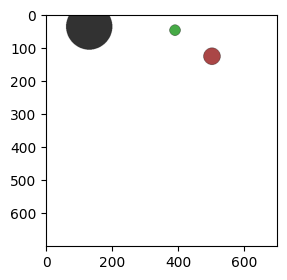

[10.0, -10.0]

In [5]:
play(True)[-1]